## 3. CRISP-DM: Data Understanding

In [35]:

# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
import re
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score
from shapely.geometry import Point 
import geopandas as gpd
import tilemapbase

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')


### 3.1 Data Description
Die Daten für die Analyse stammen aus dem Wettbewerb „Predict West Nile Virus“ aus dem Jahr 2015 auf Kaggle. Sie liegen in vier CSV-Dateien vor und umfassen verschiedene Datensätze. Der Hauptdatensatz besteht aus Trainings- und Testdaten. Die Trainingsdatensätze umfassen insgesamt 10.506 Datensätze aus den Jahren 2007, 2009, 2011 und 2013. Der Testdatensatz umfasst die Jahre 2008, 2010, 2012 und 2014 und enthält insgesamt 116.293 Datensätze. Jeder Datensatz enthält das Datum des Tests (Date), eine ungefähre Adresse des Standorts der Falle (Address), die Mückenart (Species), die Blocknummer der Adresse (Block), den Straßennamen (Street) und eine ID der Falle (Trap). Darüber hinaus werden geografische Informationen in Breitengrad (Latitude) und Längengrad (Longitude) umgewandelt. Die Genauigkeit dieser Geokodierung wird im Feld „AddressAccuracy“ angegeben. Zusätzlich wird die Anzahl der in der jeweiligen Falle gefangenen Stechmücken (NumMosquitos) angegeben. Das entscheidende Merkmal dieser Daten ist jedoch „WnvPresent“, das angibt, ob das West-Nil-Virus in den gefangenen Mücken vorhanden war oder nicht (1 = vorhanden, 0 = nicht vorhanden). Dieses Feld ist die Zielvariable im Vorhersagemodell.

Zusätzlich werden noch Wetterdatensätze aus der NOAA (National Weather Service) beigefügt. Diese umfassen 2.945 Wetterdatensätze zwischen Mai 2007 und Oktober 2014, die von zwei Wetterstationen stammen und verschiedene Wetterbedingungen wie z. B. die Tages-Maximaltemperatur (Tmax), den durchschnittlichen Taupunkt (DewPoint) oder die Niederschlagsmenge (PrecipTotal) an den verschiedenen Tagen dokumentieren. Als Maßnahmen zur Mückenbekämpfung werden in den Sprühdatensätzen Daten über Sprühaktionen dokumentiert. Die Sprühdatensätze umfassen das Datum und den Zeitpunkt der gesprühten Orte aus den Jahren 2011 bis 2013. Die Orte sind in GIS-Daten, also Longitude und Latitude, angegeben.


### 3.2 Attribute Understanding

**Wetterdaten**

| **Attribut**   | **Dimension**          | **Beschreibung**                                                                                                                                                                                                                     |
|----------------|------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Station**    | Kategorisch: 1, 2      | Messstation <br> 1 = CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level <br> 2 = CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level                           |
| **Date**       | Datum: DD-MM-YYYY      | Tag der Messung                                                                                                                                                                                                                      |
| **Tmax**       | Integer                | Tages-Maximal-Temperatur, in Fahrenheit                                                                                                                                                                                              |
| **Tmin**       | Integer                | Tages-Minimal-Temperatur, in Fahrenheit                                                                                                                                                                                              |
| **Tavg**       | Integer                | Tages-Durchschnittstemperatur, in Fahrenheit                                                                                                                                                                                         |
| **Depart**     | Integer                | Abweichung Temperaturwertes vom langjährigen Durchschnitt oder Normalwert für denselben Zeitraum                                                                                                                                     |
| **DewPoint**   | Integer                | Durchschnittlicher Taupunkt (Temperatur, bei der die Luft vollständig gesättigt ist und Wasser zu kondensieren beginnt)                                                                                                               |
| **WetBulb**    | Integer                | Durchschnittliche Kühlgrenztemperatur (niedrigste Temperatur, die durch Verdunstungskühlung erreicht werden kann)                                                                                                                     |
| **Heat**       | Integer                | Heizgradtage (Differenz zwischen Tages-Durchschnittstemperatur und festgelegter Heizgrenze (65°F), Temperatur ist geringer als Durchschnittstemperatur), in Fahrenheit                                                               |
| **Cool**       | Integer                | Kühlgradtage (Differenz zwischen Tages-Durchschnittstemperatur und festgelegter Heizgrenze (65°F), Temperatur ist höher als Durchschnittstemperatur), in Fahrenheit                                                                  |
| **Sunrise**    | Integer                | berechneter Sonnenaufgang                                                                                                                                                                                                            |
| **Sunset**     | Integer                | berechneter Sonnenuntergang                                                                                                                                                                                                          |
| **CodeSum**    | Kategorisch            | Wetterart: <br> FC TORNADO/WATERSPOUT <br> FC  FUNNEL CLOUD <br> TS  THUNDERSTORM <br> GR  HAIL <br> RA  RAIN <br> DZ  DRIZZLE <br> SN  SNOW <br> SG  SNOW GRAINS <br> GS  SMALL HAIL &/OR SNOW PELLETS <br> PL  ICE PELLETS <br> IC  ICE CRYSTALS <br> FG+ HEAVY FOG (FG & LE.25 MILES VISIBILITY) <br> FG  FOG <br> BR  MIST <br> UP  UNKNOWN PRECIPITATION <br> HZ  HAZE <br> FU  SMOKE <br> VA  VOLCANIC ASH <br> DU  WIDESPREAD DUST <br> DS  DUSTSTORM <br> PO  SAND/DUST WHIRLS <br> SA  SAND <br> SS  SANDSTORM <br> PY  SPRAY <br> SQ  SQUALL  <br> DR  LOW DRIFTING <br> SH  SHOWER <br> FZ  FREEZING <br> MI  SHALLOW <br> PR  PARTIAL <br> BC  PATCHES <br> BL  BLOWING <br> VC  VICINITY <br> -   LIGHT <br> +   HEAVY <br> "NO SIGN" MODERATE    |
| **Depth**      | Integer                | Schneetiefe (in Zoll)                                                                                                                                                                                                                |
| **Water1**     | Integer?               | Wasseräquivalent des Schnees am Boden                                                                                                                                                                                                |
| **SnowFall**   | Float                  | Schneemange (Tiefe), T = Trace, M = missing data                                                                                                                                                                                     |
| **PrecipTotal**| Float                  | Menge an Niederschlag                                                                                                                                                                                                                |
| **StnPressure**| Float                  | Stattionsdruck; Luftdruck, der direkt an der Wetterstation gemessen wird, in Zoll Hg                                                                                                                                                  |
| **SeaLevel**   | Float                  | Luftdruck auf Meereshöhe                                                                                                                                                                                                             |
| **ResultSpeed**| Float                  | Windgeschwindigkeit in mph                                                                                                                                                                                                           |
| **ResultDir**  | Integer                | Windrichtung in Kompassgeraden                                                                                                                                                                                                       |
| **AvgSpeed**   | Float                  | Durchschnittliche Windgeschwindigkeit                                                                                                                                                                                                |


**Spray-Daten**


| **Attribut**  | **Dimension**    | **Beschreibung**                   |
|---------------|------------------|------------------------------------|
| **Date**      | Datum, DD-MM-YYYY| Datum, wann gesprüht wurde         |
| **Time**      | Zeit, hh:mm:ss   | Zeit, wann gesprüht wurde          |
| **Latitude**  | Breitengrad      | Breitengrad, wo gesprüht wurde     |
| **Longitude** | Längengrad       | Längengrad, wo gesprüht wurde      |


**Trainingsdaten**

| **Attribut**                | **Dimension**          | **Beschreibung**                                                                                               |
|-----------------------------|------------------------|---------------------------------------------------------------------------------------------------------------|
| **Date**                    | Datum, DD-MM-YYYY      | Datum, an dem der WNV-Test durchgeführt wird                                                                  |
| **Address**                 | String                 | Ungefähre Adresse des Standorts der Falle                                                                     |
| **Species**                 | String                 | Stechmückenart                                                                                                 |
| **Block**                   | Integer                | Blocknummer der Adresse                                                                                       |
| **Street**                  | String                 | Straßenname                                                                                                   |
| **Trap**                    | Kategorisch?           | ID der Falle                                                                                                  |
| **AddressNumberAndStreet**  | String                 | Ungefähre Adresse, die von GeoCoder zurückgegeben wurde                                                       |
| **Latitude**                | Float                  | Breitengrad, vom GeoCoder zurückgegeben                                                                       |
| **Longitude**               | Float                  | Längengrad, vom GeoCoder zurückgegeben                                                                        |
| **AddressAccuracy**         | Integer                | Von GeoCoder zurückgegebene Genauigkeit                                                                       |
| **NumMosquitos**            | Integer                | Anzahl der in dieser Falle gefangenen Stechmücken                                                             |
| **WnvPresent**              | Boolean                | Ob das West-Nil-Virus in diesen Mücken vorhanden war. 1 = ist vorhanden, 0 = ist nicht vorhanden               |


### 3.3 Data Quality





**weather.csv**

Die Daten von folgenden Attributen sind entweder unvollständig oder fragwürdig.


| Attribute    | Fehlende Werte       | Bemerkung                                |
|--------------|----------------------|------------------------------------------|
| Tavg         | 11                   |                                          |
| Depart       | 1.472                | Daten nur aus Station 2                            |
| WetBulb      | 4                    |                                          |
| Heat         | 11                   |                                          |
| Cool         | 11                   |                                          |
| Sunrise      | 1.472                | Daten nur aus Station 2                            |
| Sunset       | 1.472                | Daten nur aus Station 2                            |
| CodeSum      | 1.609                |                                          |
| Depth        | 1.472                | Daten nur aus Station 2                            |
| Water        | 2.944 (alle)         |                                          |
| Snowfall     | 1.472                | Daten nur aus Station 2                            |
| StnPressure  | 4                    |                                          |
| SeaLevel     | 9                    |                                          |
| AvgSpeed     | 3                    |                                          |
| StnPressure  | vollständig          |158 Aufzeichnungen, die 0 oder T anzeigen, aber in den Wetterarten(CodeSum) eindeutig als Regenfälle (mit RA, DZ, SH) aufgeführt sind|       

**spray.csv**

Nur die Daten "Time" sind nicht vollständig und es fehlt 584 Daten


**train.csv & test.csv**

Die Daten aus den zwei Tabellen sind vollständig, aber bei Test-Data gibt es ein unklare Species "UNSPECIFIED CULEX".


### 3.4 Data Visualization

##### Abhängigkeit der WNV-Präsenz von Moskitoanzahl und Temperatur

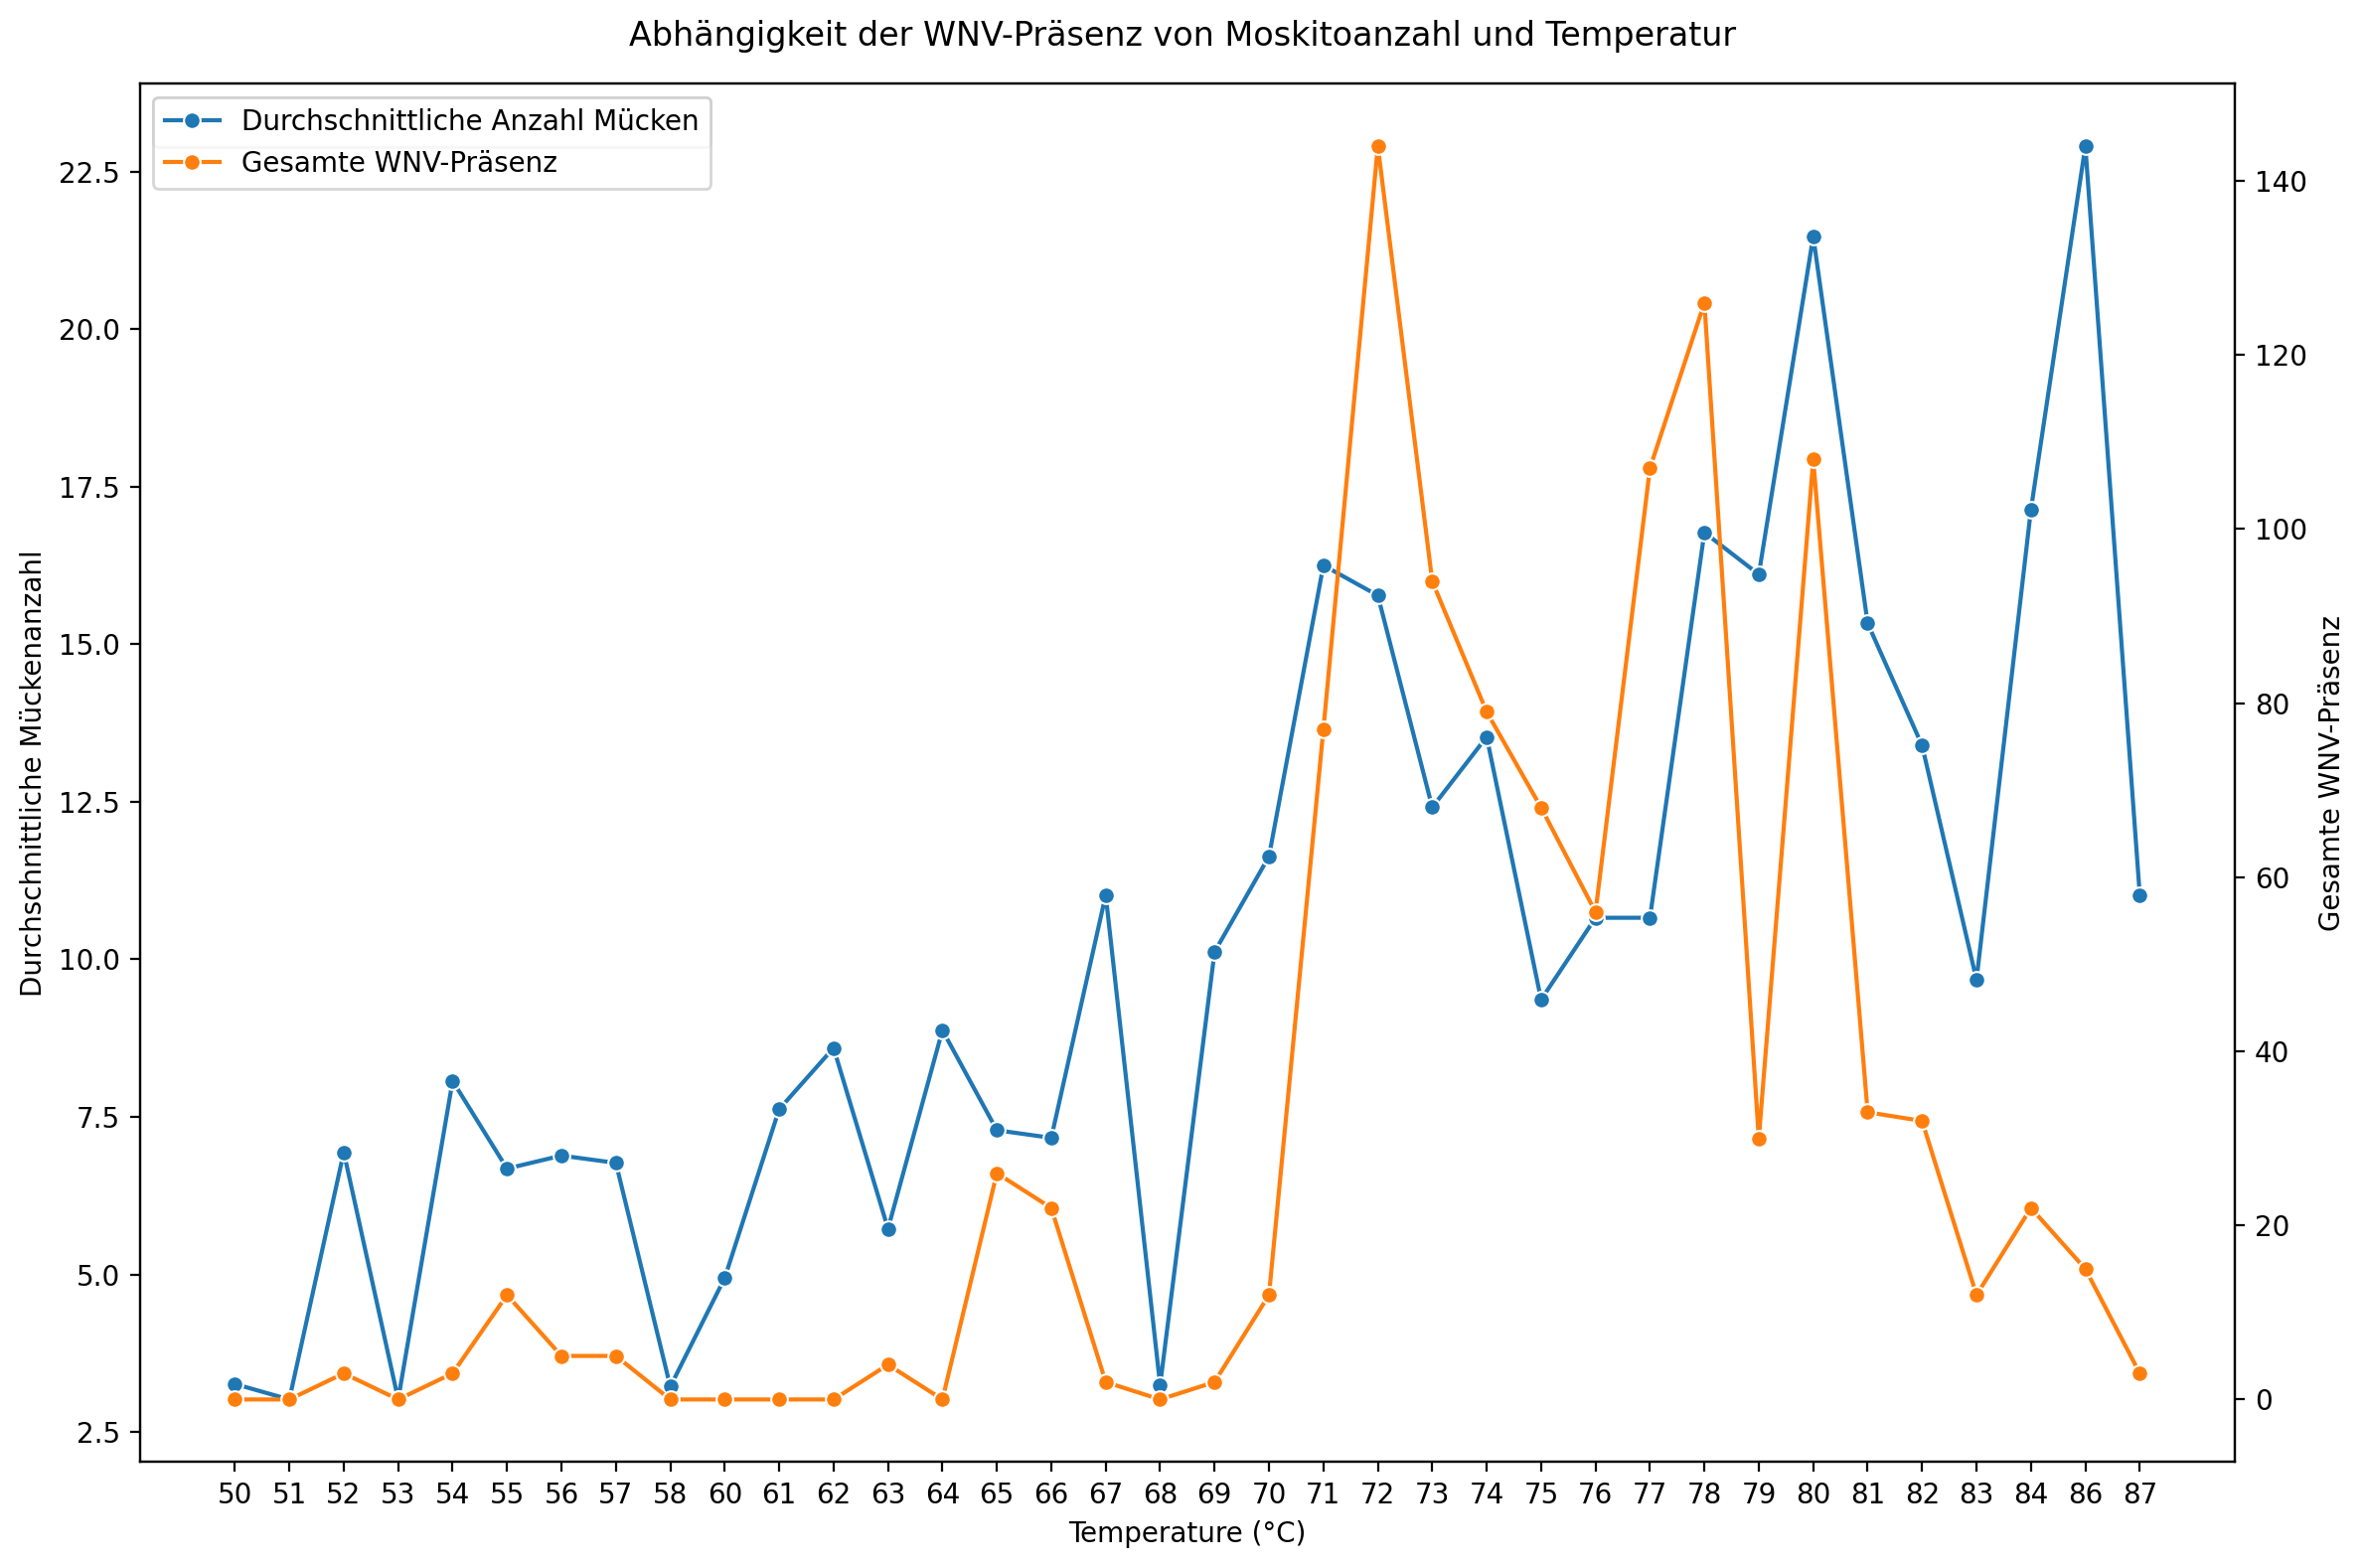

In [210]:
# Dateien einlesen
mosquito_data_path = '../data/train.csv'
weather_data_path = '../data/weather.csv'

# Dataframe erstellen
mosquito_df = pd.read_csv(mosquito_data_path)
weather_df = pd.read_csv(weather_data_path)

# Konvertieren von 'Date' in Datetime-Format
mosquito_df['Date'] = pd.to_datetime(mosquito_df['Date'], format='%Y-%m-%d')
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

if 'Tavg' in weather_df.columns:
    weather_df['Temp'] = weather_df['Tavg']
else:
    # Durchschnittstemperatur berechnen (falls Min/Max-Temperatur vorhanden)
    if 'Tmax' in weather_df.columns and 'Tmin' in weather_df.columns:
        weather_df['Temp'] = (weather_df['Tmax'] + weather_df['Tmin']) / 2
    else:
        raise ValueError("Keine Temperaturdaten gefunden")

# Merge Datensätze auf Basis des Datums
merged_df = pd.merge(mosquito_df, weather_df[['Date', 'Temp']], on='Date')

# Konvertieren von 'NumMosquitos' in Integer
merged_df['NumMosquitos'] = merged_df['NumMosquitos'].astype(int)

# Berechnen des Durchschnitts der Anzahl der Mücken und der WnvPresence für jede Temperatur
avg_values_per_temp = merged_df.groupby('Temp').agg({'NumMosquitos': 'mean', 'WnvPresent': 'sum'}).reset_index()

# Plot erstellen
fig, ax1 = plt.subplots(figsize=(12, 8))

# Durchschnitt Mückenanzahl
color = 'tab:blue'
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Durchschnittliche Mückenanzahl')
sns.lineplot(data=avg_values_per_temp, x='Temp', y='NumMosquitos', marker='o', ax=ax1, color=color, label='Durchschnittliche Anzahl Mücken')
ax1.tick_params(axis='y')

# Zweite Y-Achse für WnvPresence
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Gesamte WNV-Präsenz')
sns.lineplot(data=avg_values_per_temp, x='Temp', y='WnvPresent', marker='o', ax=ax2, color=color, label='Gesamte WNV-Präsenz')
ax2.tick_params(axis='y')

# Titel 
fig.suptitle('Abhängigkeit der WNV-Präsenz von Moskitoanzahl und Temperatur')

# Legenden 
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
plt.show()

##### Mückenart und WNV-Präsenz

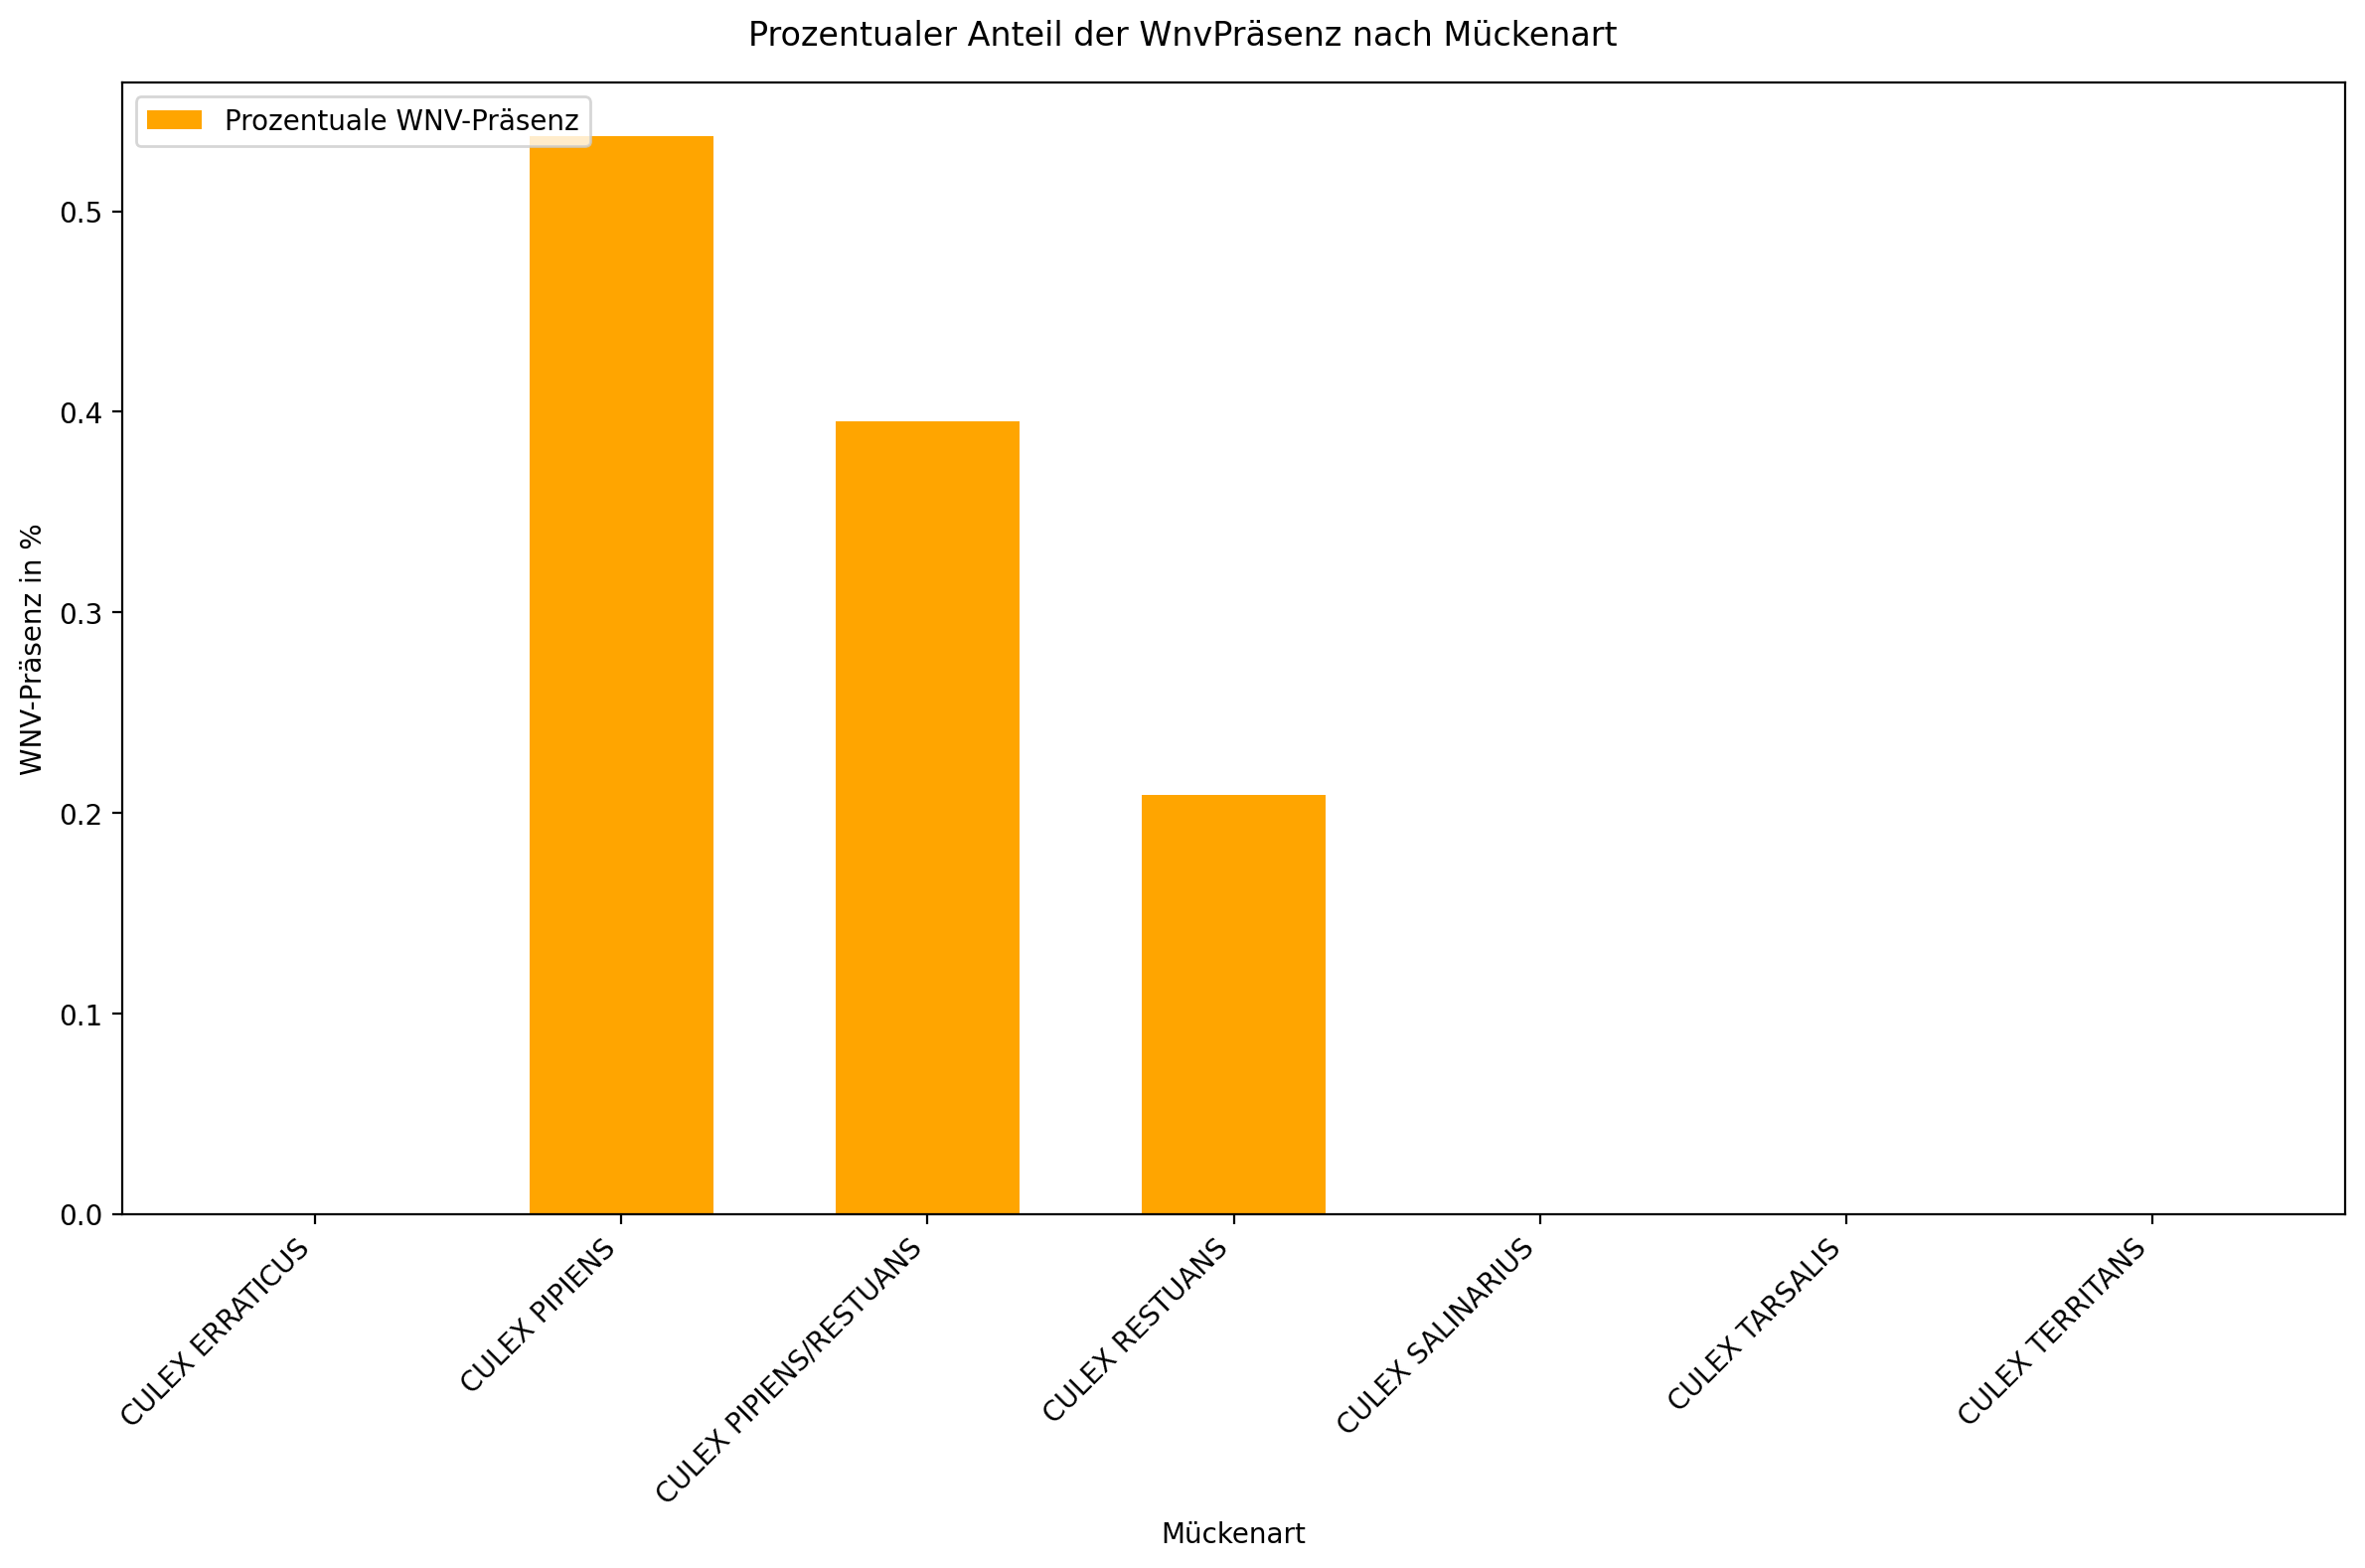

In [211]:
# Datei einlesen
file_path = '../data/train.csv'
df = pd.read_csv(file_path)

# Konvertieren von 'NumMosquitos' und 'WnvPresent' in Integer
df['NumMosquitos'] = df['NumMosquitos'].astype(int)
df['WnvPresent'] = df['WnvPresent'].astype(int)

# Gruppieren nach 'Species' und Aggregieren der Summen
species_counts = df.groupby('Species').agg({'NumMosquitos': 'sum', 'WnvPresent': 'sum'}).reset_index()

# Berechnung des prozentualen Anteils der WnvPresence pro Spezies
species_counts['WnvPresencePercentage'] = (species_counts['WnvPresent'] / species_counts['NumMosquitos']) * 100

# Balkendiagramm erstellen
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.6
index = np.arange(len(species_counts))

# Balken für den prozentualen Anteil der WnvPresence
bars = ax.bar(index, species_counts['WnvPresencePercentage'], bar_width, label='Prozentuale WNV-Präsenz', color='orange')
ax.set_xlabel('Mückenart')
ax.set_ylabel('WNV-Präsenz in %')
ax.tick_params(axis='y')

# Achsenbeschriftungen und Titel setzen
ax.set_xticks(index)
ax.set_xticklabels(species_counts['Species'], rotation=45, ha='right')
fig.suptitle('Prozentualer Anteil der WnvPräsenz nach Mückenart')

# Legende hinzufügen
ax.legend(loc='upper left')

fig.tight_layout()
plt.show()

##### Übersicht Vorkommen der Mückenarten

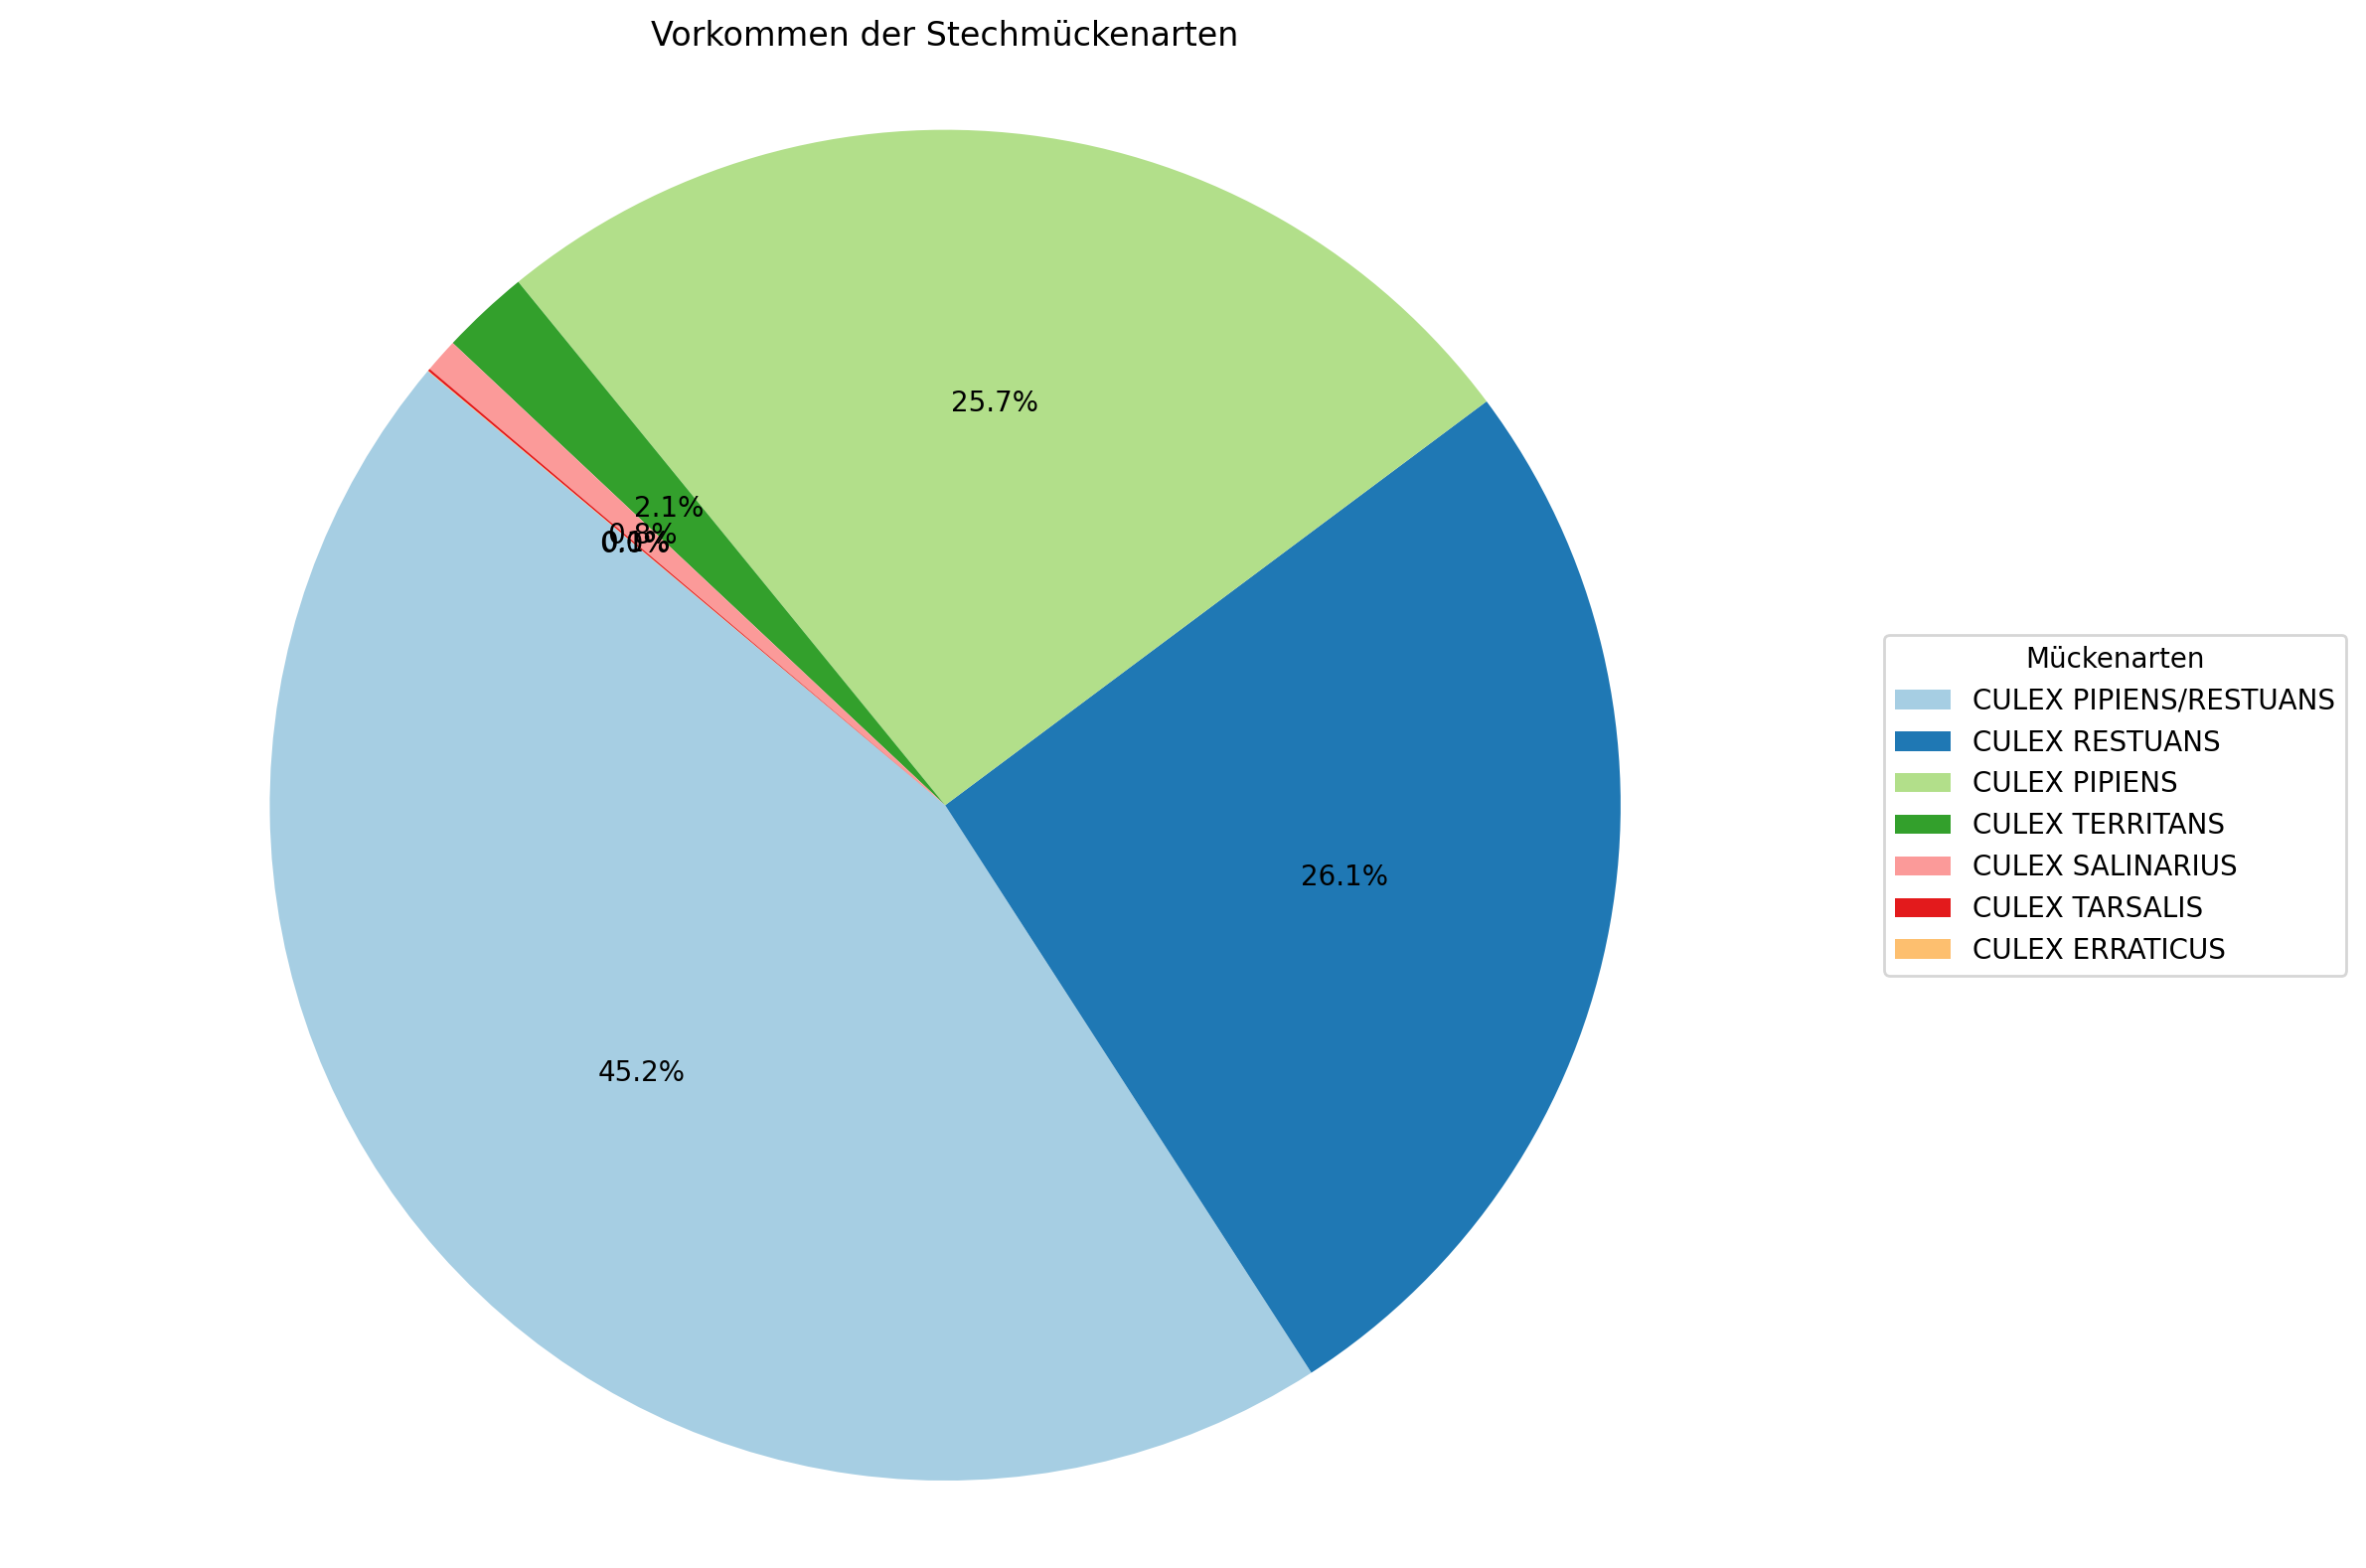

In [212]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'  # Passen Sie den Pfad zur Datei an
df = pd.read_csv(file_path)

# Gruppieren nach 'Species' und Zählen der Vorkommen
species_counts = df['Species'].value_counts()

# Kuchendiagramm erstellen
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(species_counts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Legende hinzufügen
plt.legend(wedges, species_counts.index, title='Mückenarten', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Vorkommen der Stechmückenarten')
plt.axis('equal')  # Gleichmäßige Darstellung
plt.tight_layout()
plt.show()

##### Mückenanzahl über Jahre

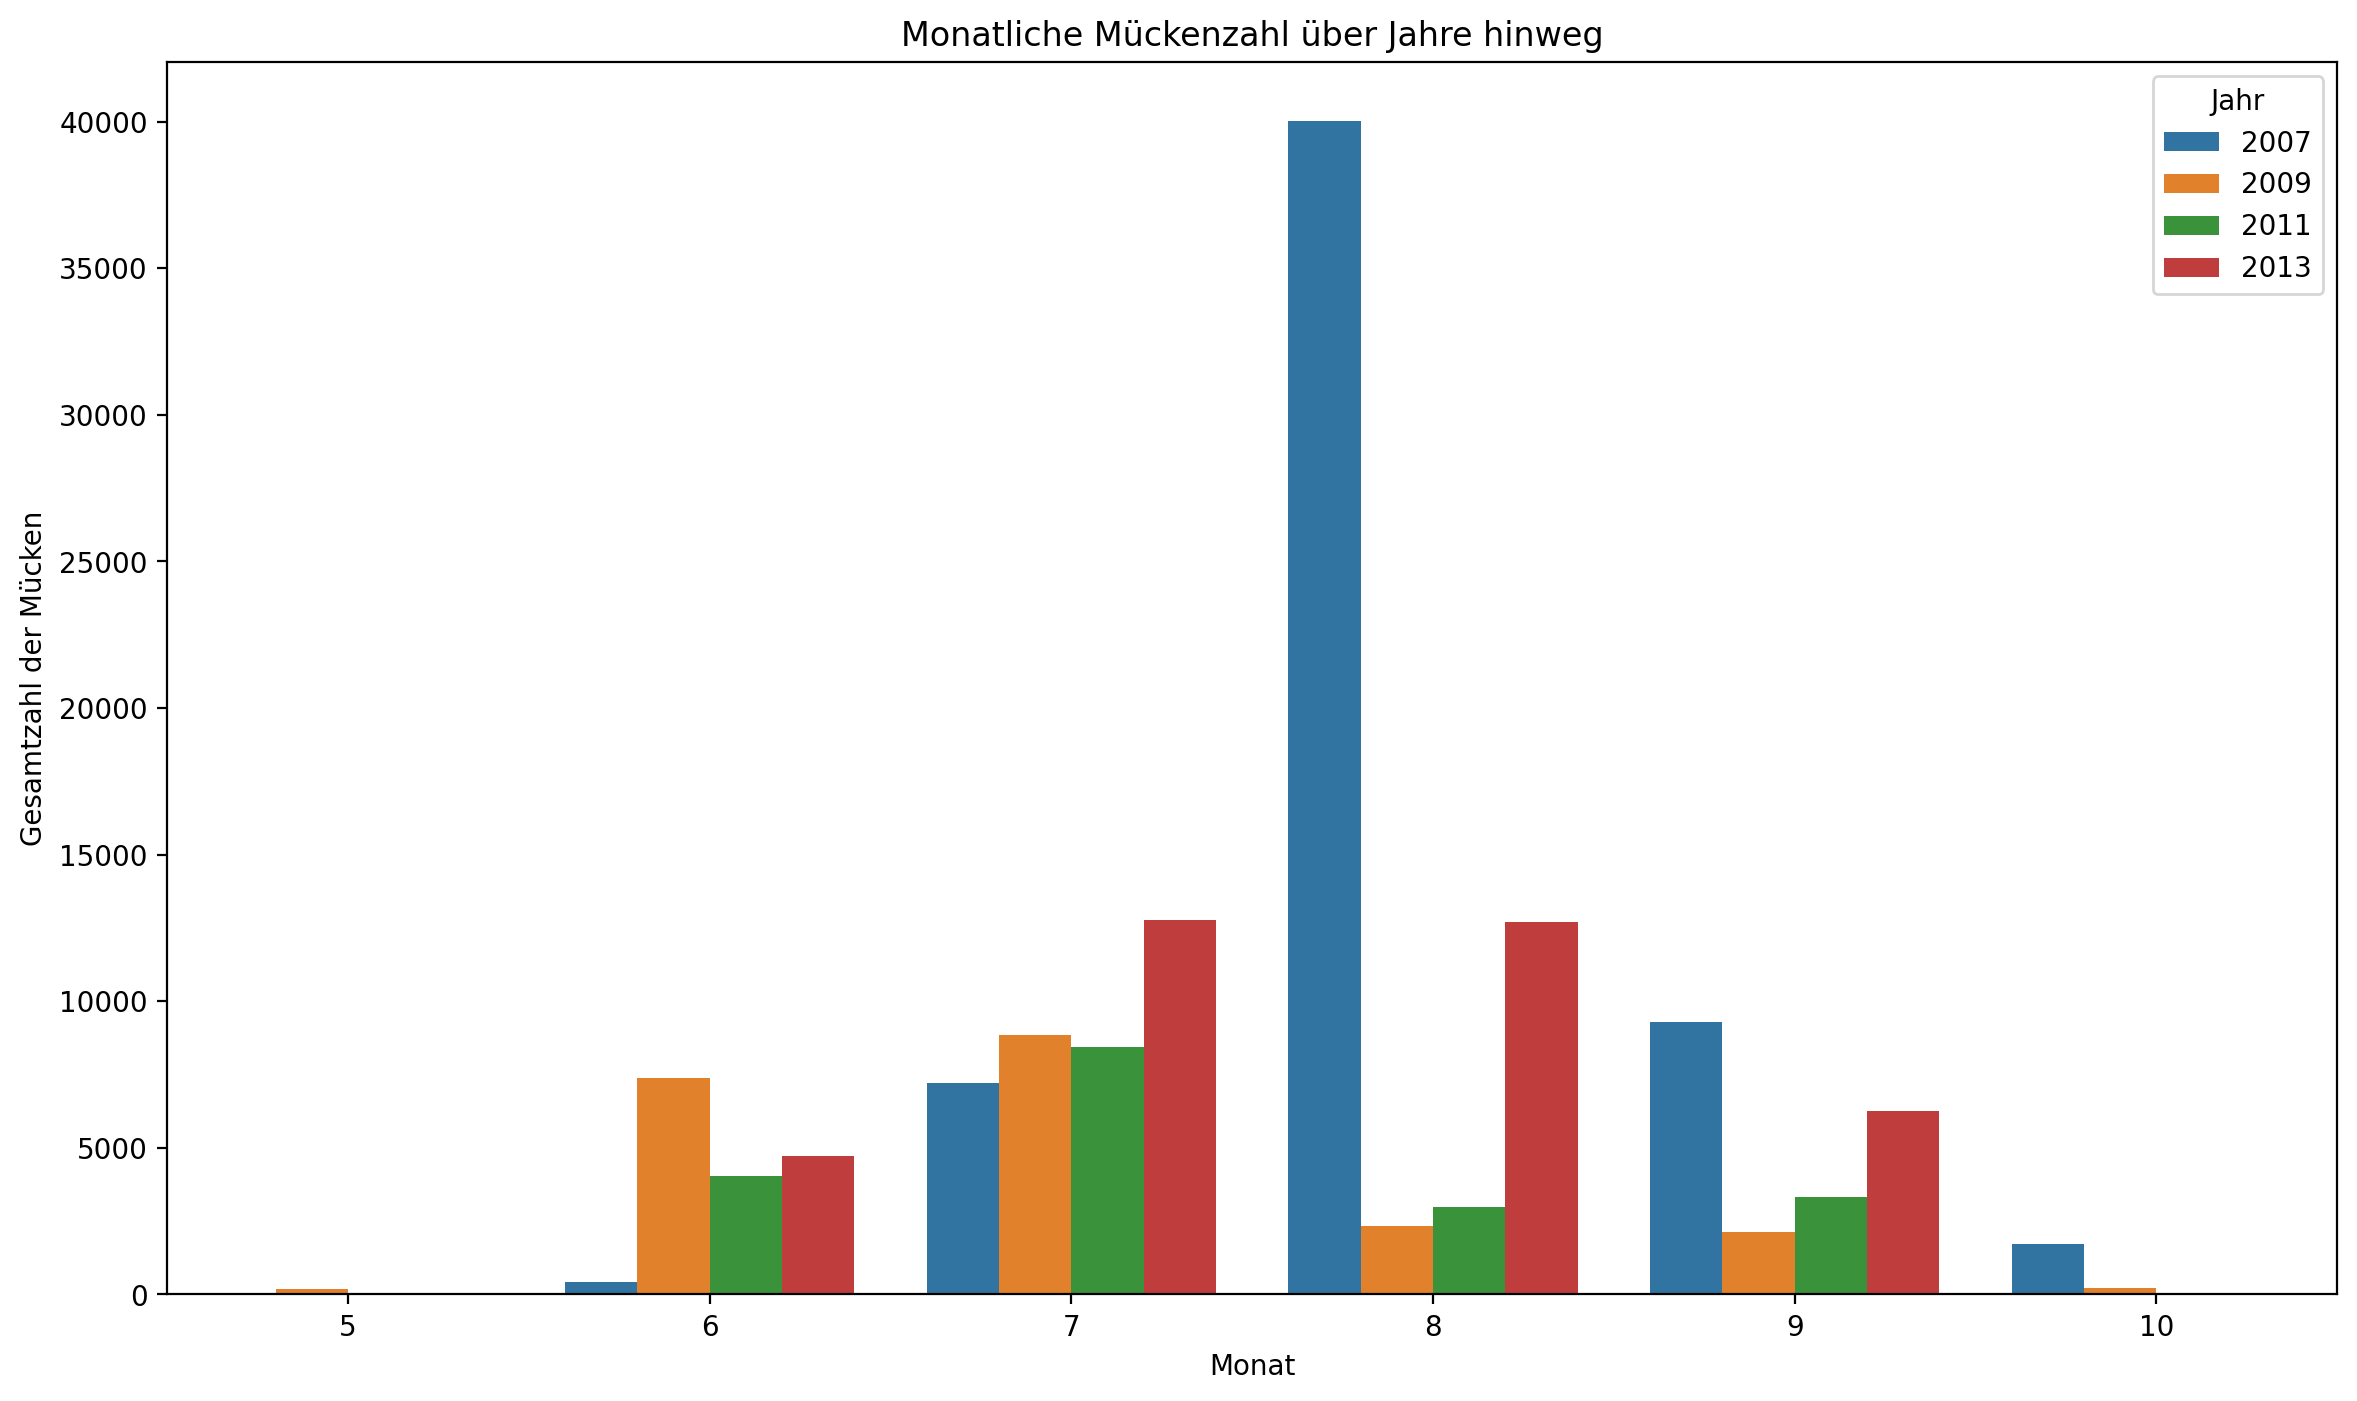

In [213]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'  # Passen Sie den Pfad zur Datei an
df = pd.read_csv(file_path)

# Konvertieren der 'Date'-Spalte in Datetime-Format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extrahieren von Jahr und Monat
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Gruppieren nach Jahr und Monat und Summieren der Anzahl der Mücken
monthly_counts = df.groupby(['Year', 'Month']).agg({'NumMosquitos': 'sum'}).reset_index()

# Bar-Chart erstellen
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='NumMosquitos', hue='Year', data=monthly_counts, palette='tab10')
plt.title('Monatliche Mückenzahl über Jahre hinweg')
plt.xlabel('Monat')
plt.ylabel('Gesamtzahl der Mücken')
plt.legend(title='Jahr')
plt.show()

##### WNV-Präsenz über Jahre

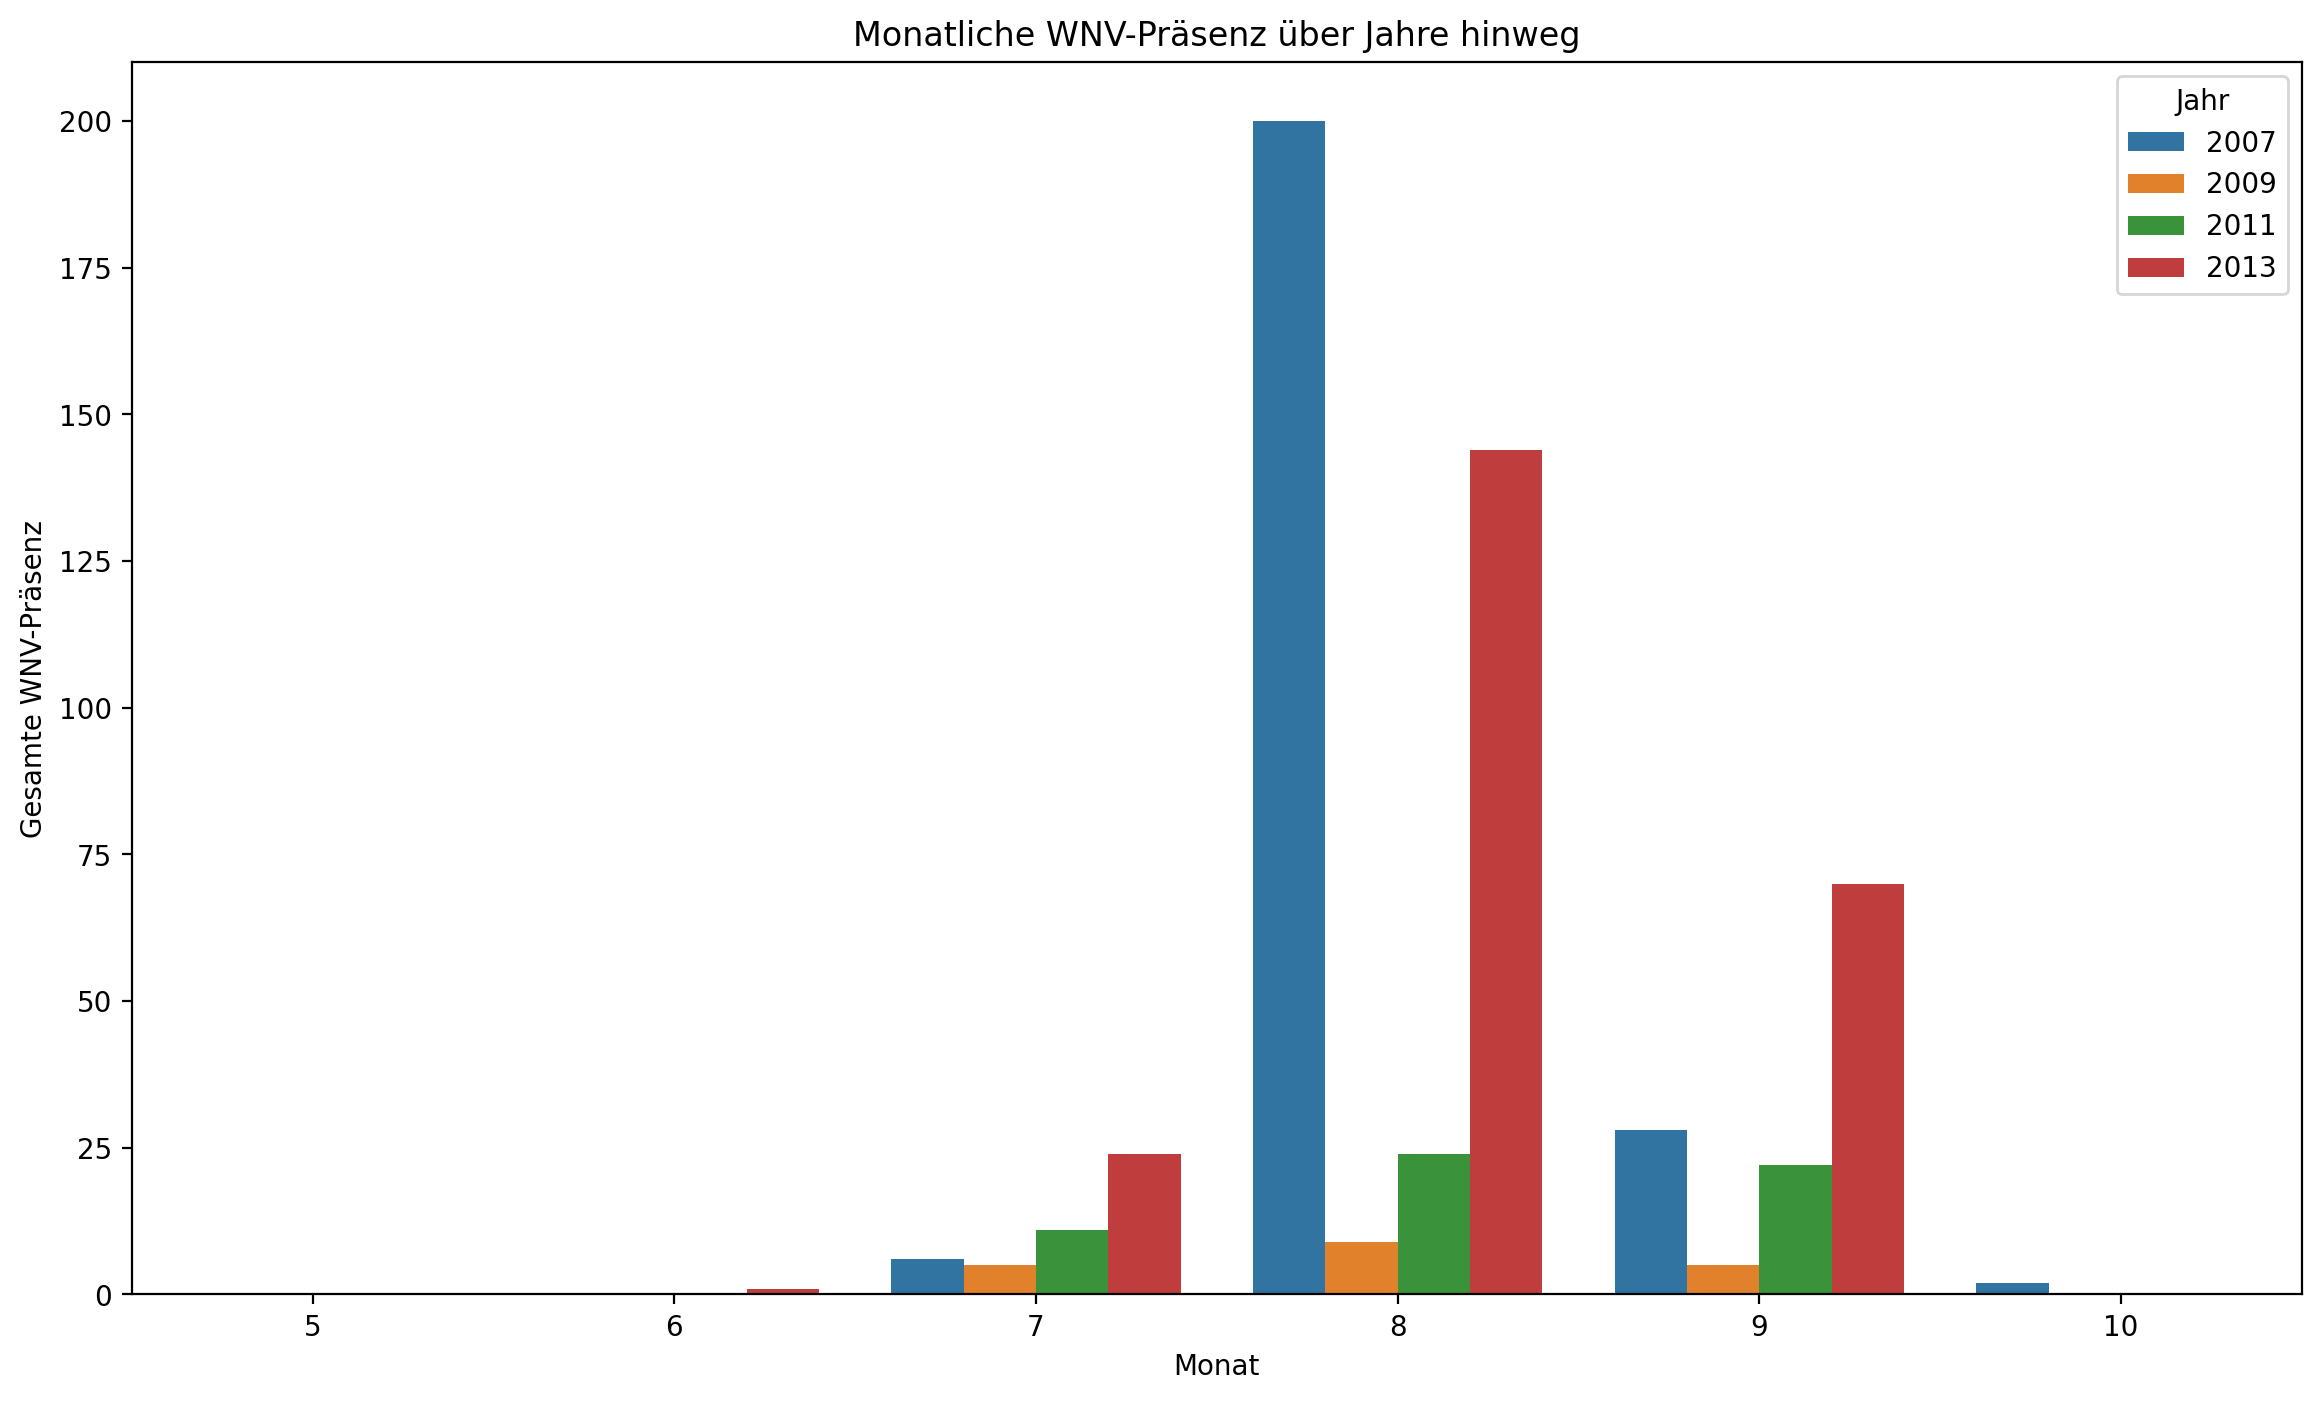

In [214]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'
df = pd.read_csv(file_path)

# Konvertieren der 'Date'-Spalte in Datetime-Format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extrahieren von Jahr und Monat
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Gruppieren nach Jahr und Monat und Summieren der Anzahl der WnvPresence
monthly_wnv_counts = df.groupby(['Year', 'Month']).agg({'WnvPresent': 'sum'}).reset_index()

# Bar-Chart erstellen
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='WnvPresent', hue='Year', data=monthly_wnv_counts, palette='tab10')
plt.title('Monatliche WNV-Präsenz über Jahre hinweg')
plt.xlabel('Monat')
plt.ylabel('Gesamte WNV-Präsenz')
plt.legend(title='Jahr')
plt.show()

TODO: Korrelationsmatrix --> hatte ich probiert, kam dann leider nicht weiter, wie ich damit umgehen kann, dass die Daten, die ich für die Korrelation vergleichen will, nicht aus der gleichen File kommen. Muss mir das daher nochmal anschauen

- `train.csv` und `test.csv`: Training und Testdatensätze.

- `weather.csv`: Wetterdaten von 2007 bis 2014.

- `spray.csv`: GIS-Daten von Sprühaktionen in 2011 und 2013.


##### Visualisierung aller Traps in Map


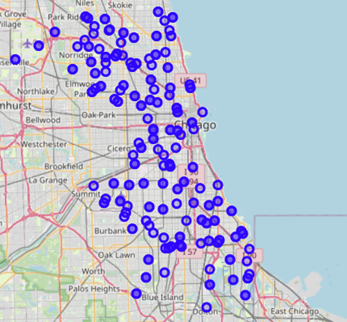

##### Spraybereich

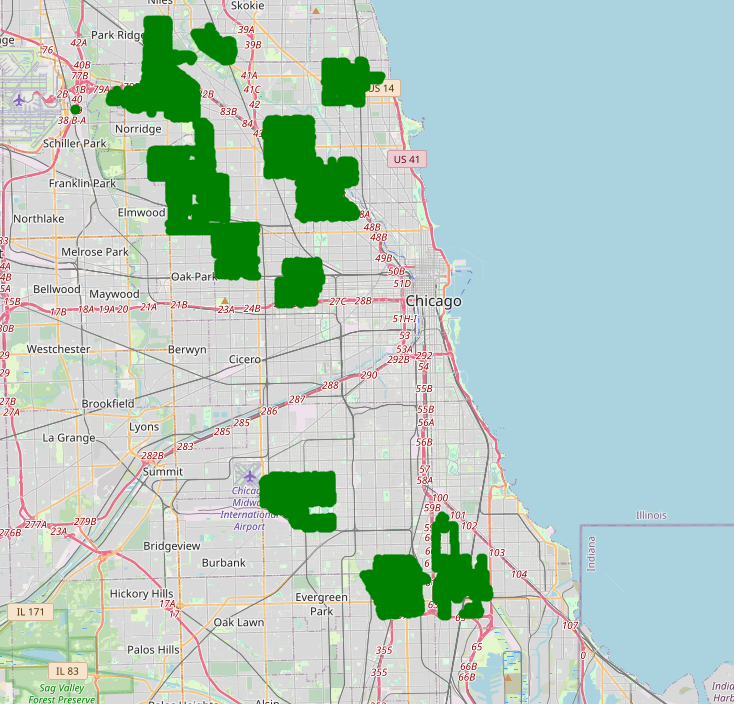

- `Date`: Datum des Tests.

- `Species`: Mückenart.

- `Trap`: ID der Falle.

- `NumMosquitos`: Anzahl der gefangenen Mücken.

- `WnvPresent`: WNV vorhanden (1: Ja, 0: Nein).

- `Latitude` und `Longitude`: Geografische Koordinaten.

## Korrelationsmatrix

In [7]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')

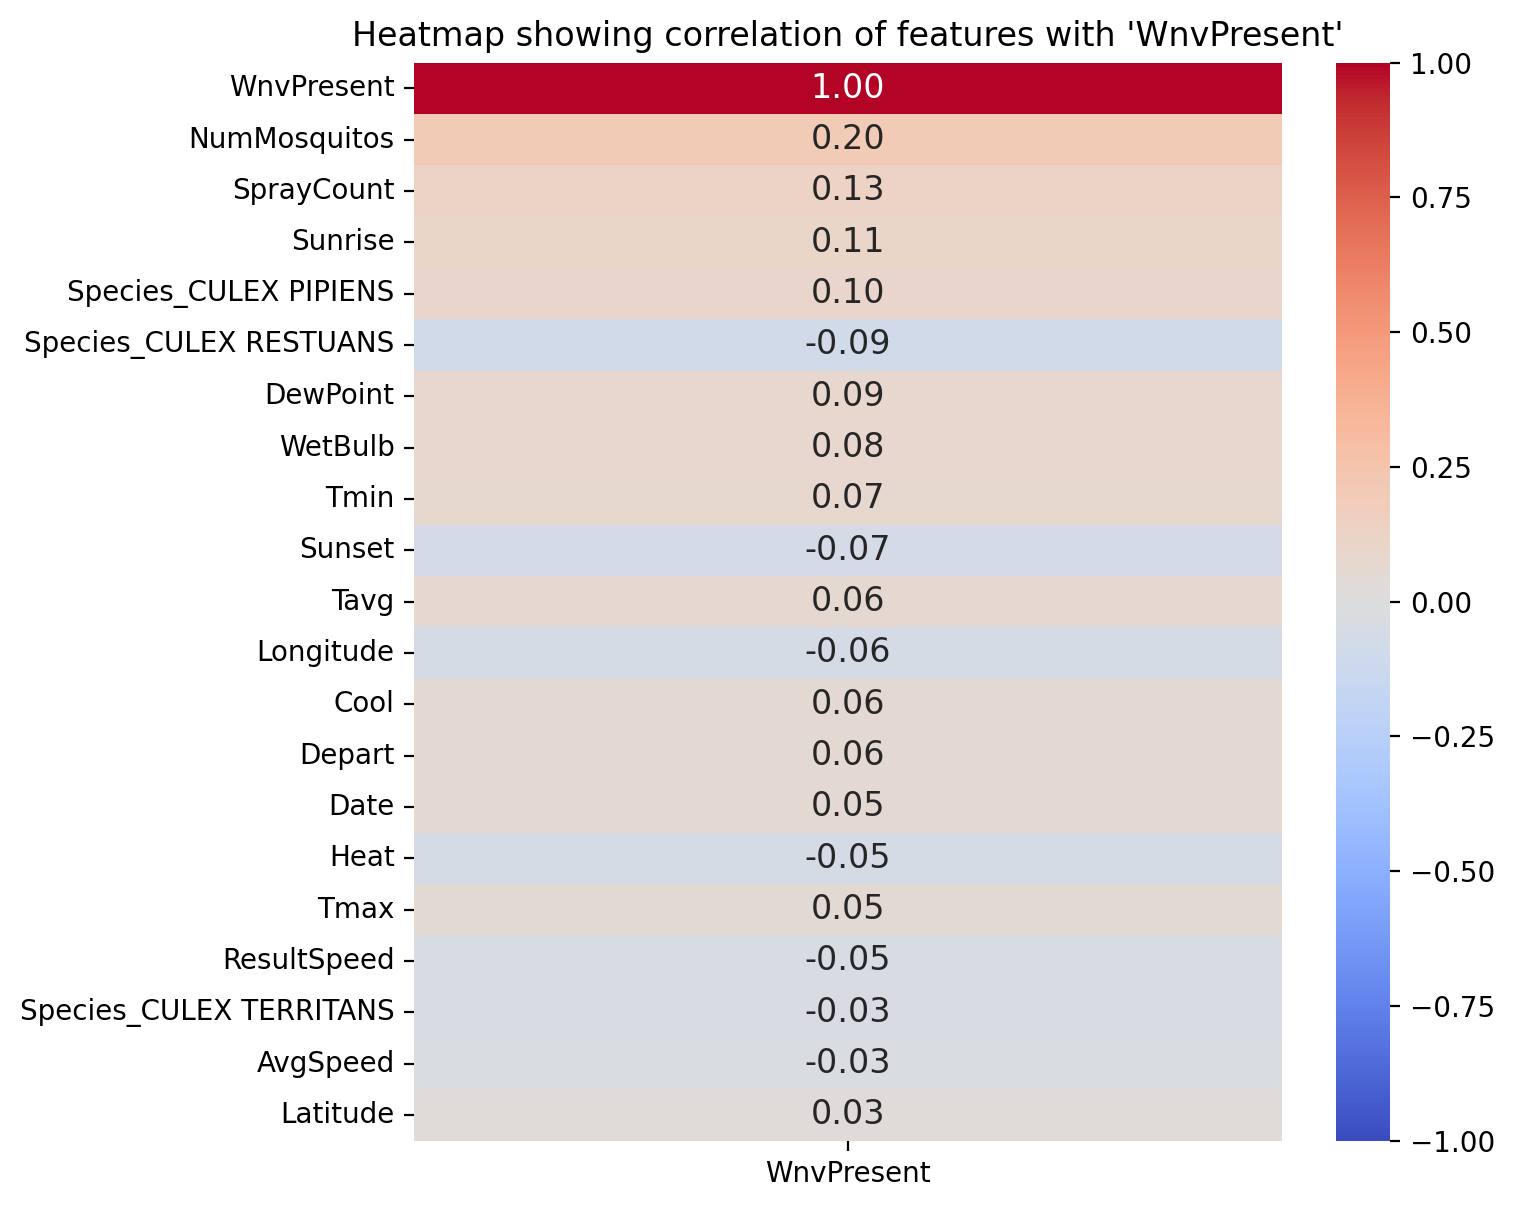

In [216]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# We preprocess data in  order to display a heatmap
def preprocess_data(train, weather, spray, numeric_columns, columns_to_drop):
    # Convert Date columns to datetime
    train['Date'] = pd.to_datetime(train['Date'])
    weather['Date'] = pd.to_datetime(weather['Date'])
    spray['Date'] = pd.to_datetime(spray['Date'])

    # Drop specified columns
    train.drop(columns=columns_to_drop, inplace=True)
    weather.drop(columns=['CodeSum'], inplace=True)  # Assuming 'CodeSum' is not required

    # Convert specified columns in 'weather' to numeric
    for column in numeric_columns:
        weather[column] = pd.to_numeric(weather[column], errors='coerce')

    # One-hot encode categorical variables in 'weather', excluding 'Date'
    weather_encoded = pd.get_dummies(weather, columns=weather.select_dtypes(exclude='number').columns.difference(['Date']))

    # Aggregate numeric weather data by date
    weather_agg = weather_encoded.groupby('Date').mean().reset_index()

    # Aggregate spray data by date and count sprays
    spray_agg = spray.groupby('Date').size().reset_index(name='SprayCount')

    # Merge all dataframes
    merged_data = pd.merge(train, weather_agg, on='Date', how='left')
    merged_data = pd.merge(merged_data, spray_agg, on='Date', how='left')

    # Fill NaN values for 'SprayCount' after merge
    merged_data['SprayCount'].fillna(0, inplace=True)

    return merged_data

def plot_heatmap(data):
    # Perform one-hot encoding for all categorical variables in the train dataset
    data_encoded = pd.get_dummies(data)

    # Calculate the correlation matrix
    correlation_matrix = data_encoded.corr()

    # Extract the correlation with 'WnvPresent' and sort it
    target_correlation = correlation_matrix['WnvPresent'].abs().sort_values(ascending=False).head(21)

    # Prepare the dataframe for plotting: focusing only on correlations with 'WnvPresent'
    for_heatmap = correlation_matrix.loc[target_correlation.index, ['WnvPresent']]

    # Plotting the heatmap
    plt.figure(figsize=(7, 7))
    sns.heatmap(for_heatmap, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
    plt.title("Heatmap showing correlation of features with 'WnvPresent'")
    plt.show()
# Assuming train, weather, and spray DataFrames are defined elsewhere
numeric_columns = ["Tmax", "Tmin", "Tavg", "Depart", "DewPoint", "WetBulb", 
                   "Heat", "Cool", "Depth", "Water1", "SnowFall", "PrecipTotal", 
                   "StnPressure", "SeaLevel", "ResultSpeed", "ResultDir", "AvgSpeed", "Sunset", "Sunrise"]
columns_to_drop = ['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Trap']

# Preprocess and merge data
merged_data = preprocess_data(train, weather, spray, numeric_columns, columns_to_drop)

# Generate heatmap
plot_heatmap(merged_data)





##### Combined_df erstellen

In [30]:
# read in and assign dataframes
weather_df = pd.read_csv('../data/weather.csv')
train_df = pd.read_csv('../data/train.csv')

# outer merge train_df and weather_df
combined_df = pd.merge(left=train_df,right=weather_df,on="Date",how="outer")

# check number of null values in combined_df
combined_df.isnull().sum()

### Prepare train_df

# define function for lowercase letters
def clean_columns(col):
    return col.lower()

# apply lowercase to all columns in train_df
train_df.columns = [clean_columns(col) for col in train_df]

# check for duplicate rows in train_df
print(f'There are {len(train_df[train_df.duplicated()])} duplicate rows in train_df.')

# removing duplicates
train_df.drop_duplicates(inplace=True)


### Prepare weather_df

# apply lowercase to all columns in weather_df
weather_df.columns = [clean_columns(col) for col in weather_df]

# redefining weather_df for only station 1 as station 2 has too many missing values (both stations measure the same features)
weather_df = weather_df[weather_df["station"]==1]
weather_df.head()

# drop columns that are not needed
weather_df.drop(['tmax', 'tmin', 'depart', 'heat', 'cool', 'sunrise', 'sunset'], axis=1, inplace=True)

# remove rows with 'M' values (missing data) for the 'wetbulb' column
weather_df = weather_df[weather_df.wetbulb != 'M']

# define function to remove whitespace from text
def clean_text(text):
    text = re.sub(' ', '', text)
    return text

# remove whitespace in values in 'codesum' column to check for cells that are empty ("NO SIGN" = Moderate according to NOAA data documentation) 
weather_df["codesum"].map(clean_text)

# replace empty string values with "moderate" according to NOAA data documentation
weather_df["codesum"] = weather_df["codesum"].replace(" ","moderate")

# we can drop the 'depth' since all the rows have the value '0'
weather_df.drop(['depth'], axis=1, inplace=True)

# since the entire column consists of 'M' (missing values), we will drop the 'water1' column as well
weather_df.drop(['water1'], axis=1, inplace=True)

# since data was collected between May-Oct (not during winter season),
# more than half the data is missing and just under half are 0, we drop the whole column
weather_df.drop(['snowfall'], axis=1, inplace=True)

# according to  NOAA documentation, T stands for Trace amount of precipitation
# replace T with 0.005 (NEED TO COME BACK TO THIS)
weather_df["preciptotal"] = weather_df["preciptotal"].replace("  T","0.005")

# redefine weather_df without the rows with missing values ('M') in 'preciptotal' column
weather_df = weather_df[weather_df.preciptotal != 'M']
weather_df = weather_df[weather_df.stnpressure != 'M']
weather_df = weather_df[weather_df.sealevel != 'M']

# convert object data types to int and float
weather_df['tavg'] = weather_df['tavg'].astype(int)
weather_df['wetbulb'] = weather_df['wetbulb'].astype(int)
weather_df["preciptotal"] = weather_df["preciptotal"].astype(float)
weather_df['stnpressure'] = weather_df['stnpressure'].astype(float)
weather_df['sealevel'] = weather_df['sealevel'].astype(float)
weather_df['avgspeed'] = weather_df['avgspeed'].astype(float)

### Create combined_df

# outer merge train_df and weather_df
combined_df = pd.merge(left=train_df,right=weather_df,on="date",how="outer")

# drop rows with null values
combined_df = combined_df.dropna()

# since the combined_df only consists of results from station 1, we can drop the 'station' column
# additionally, to simplify our analysis, we are dropping repeated columns for the adddress.
combined_df.drop(['station', 'address', 'addressnumberandstreet'], axis = 1, inplace = True)

# cleaning 'date' column by converting to timestamp
combined_df['date'] = pd.to_datetime(combined_df['date'])

# create 3 new columns to separate to year, month and day
combined_df['year'] = combined_df['date'].apply(lambda time: time.year)
combined_df['month'] = combined_df['date'].apply(lambda time: time.month)
combined_df['day'] = combined_df['date'].apply(lambda time: time.day)

#showing information of the combined dataframe
combined_df.info()

combined_df.to_csv('../data/combined_df.csv', index = False)

There are 813 duplicate rows in train_df.
<class 'pandas.core.frame.DataFrame'>
Index: 9601 entries, 28 to 10843
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             9601 non-null   datetime64[ns]
 1   species          9601 non-null   object        
 2   block            9601 non-null   float64       
 3   street           9601 non-null   object        
 4   trap             9601 non-null   object        
 5   latitude         9601 non-null   float64       
 6   longitude        9601 non-null   float64       
 7   addressaccuracy  9601 non-null   float64       
 8   nummosquitos     9601 non-null   float64       
 9   wnvpresent       9601 non-null   float64       
 10  tavg             9601 non-null   float64       
 11  dewpoint         9601 non-null   float64       
 12  wetbulb          9601 non-null   float64       
 13  codesum          9601 non-null   object        
 14  p

##### Map Visualisierung erstellen

C:\Users\User\AppData\Local\Temp\ipykernel_21844\4101044003.py:22: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  density_plot = sns.kdeplot(
C:\Users\User\AppData\Local\Temp\ipykernel_21844\4101044003.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  density_plot = sns.kdeplot(


Text(0, 0.5, 'Latitude')

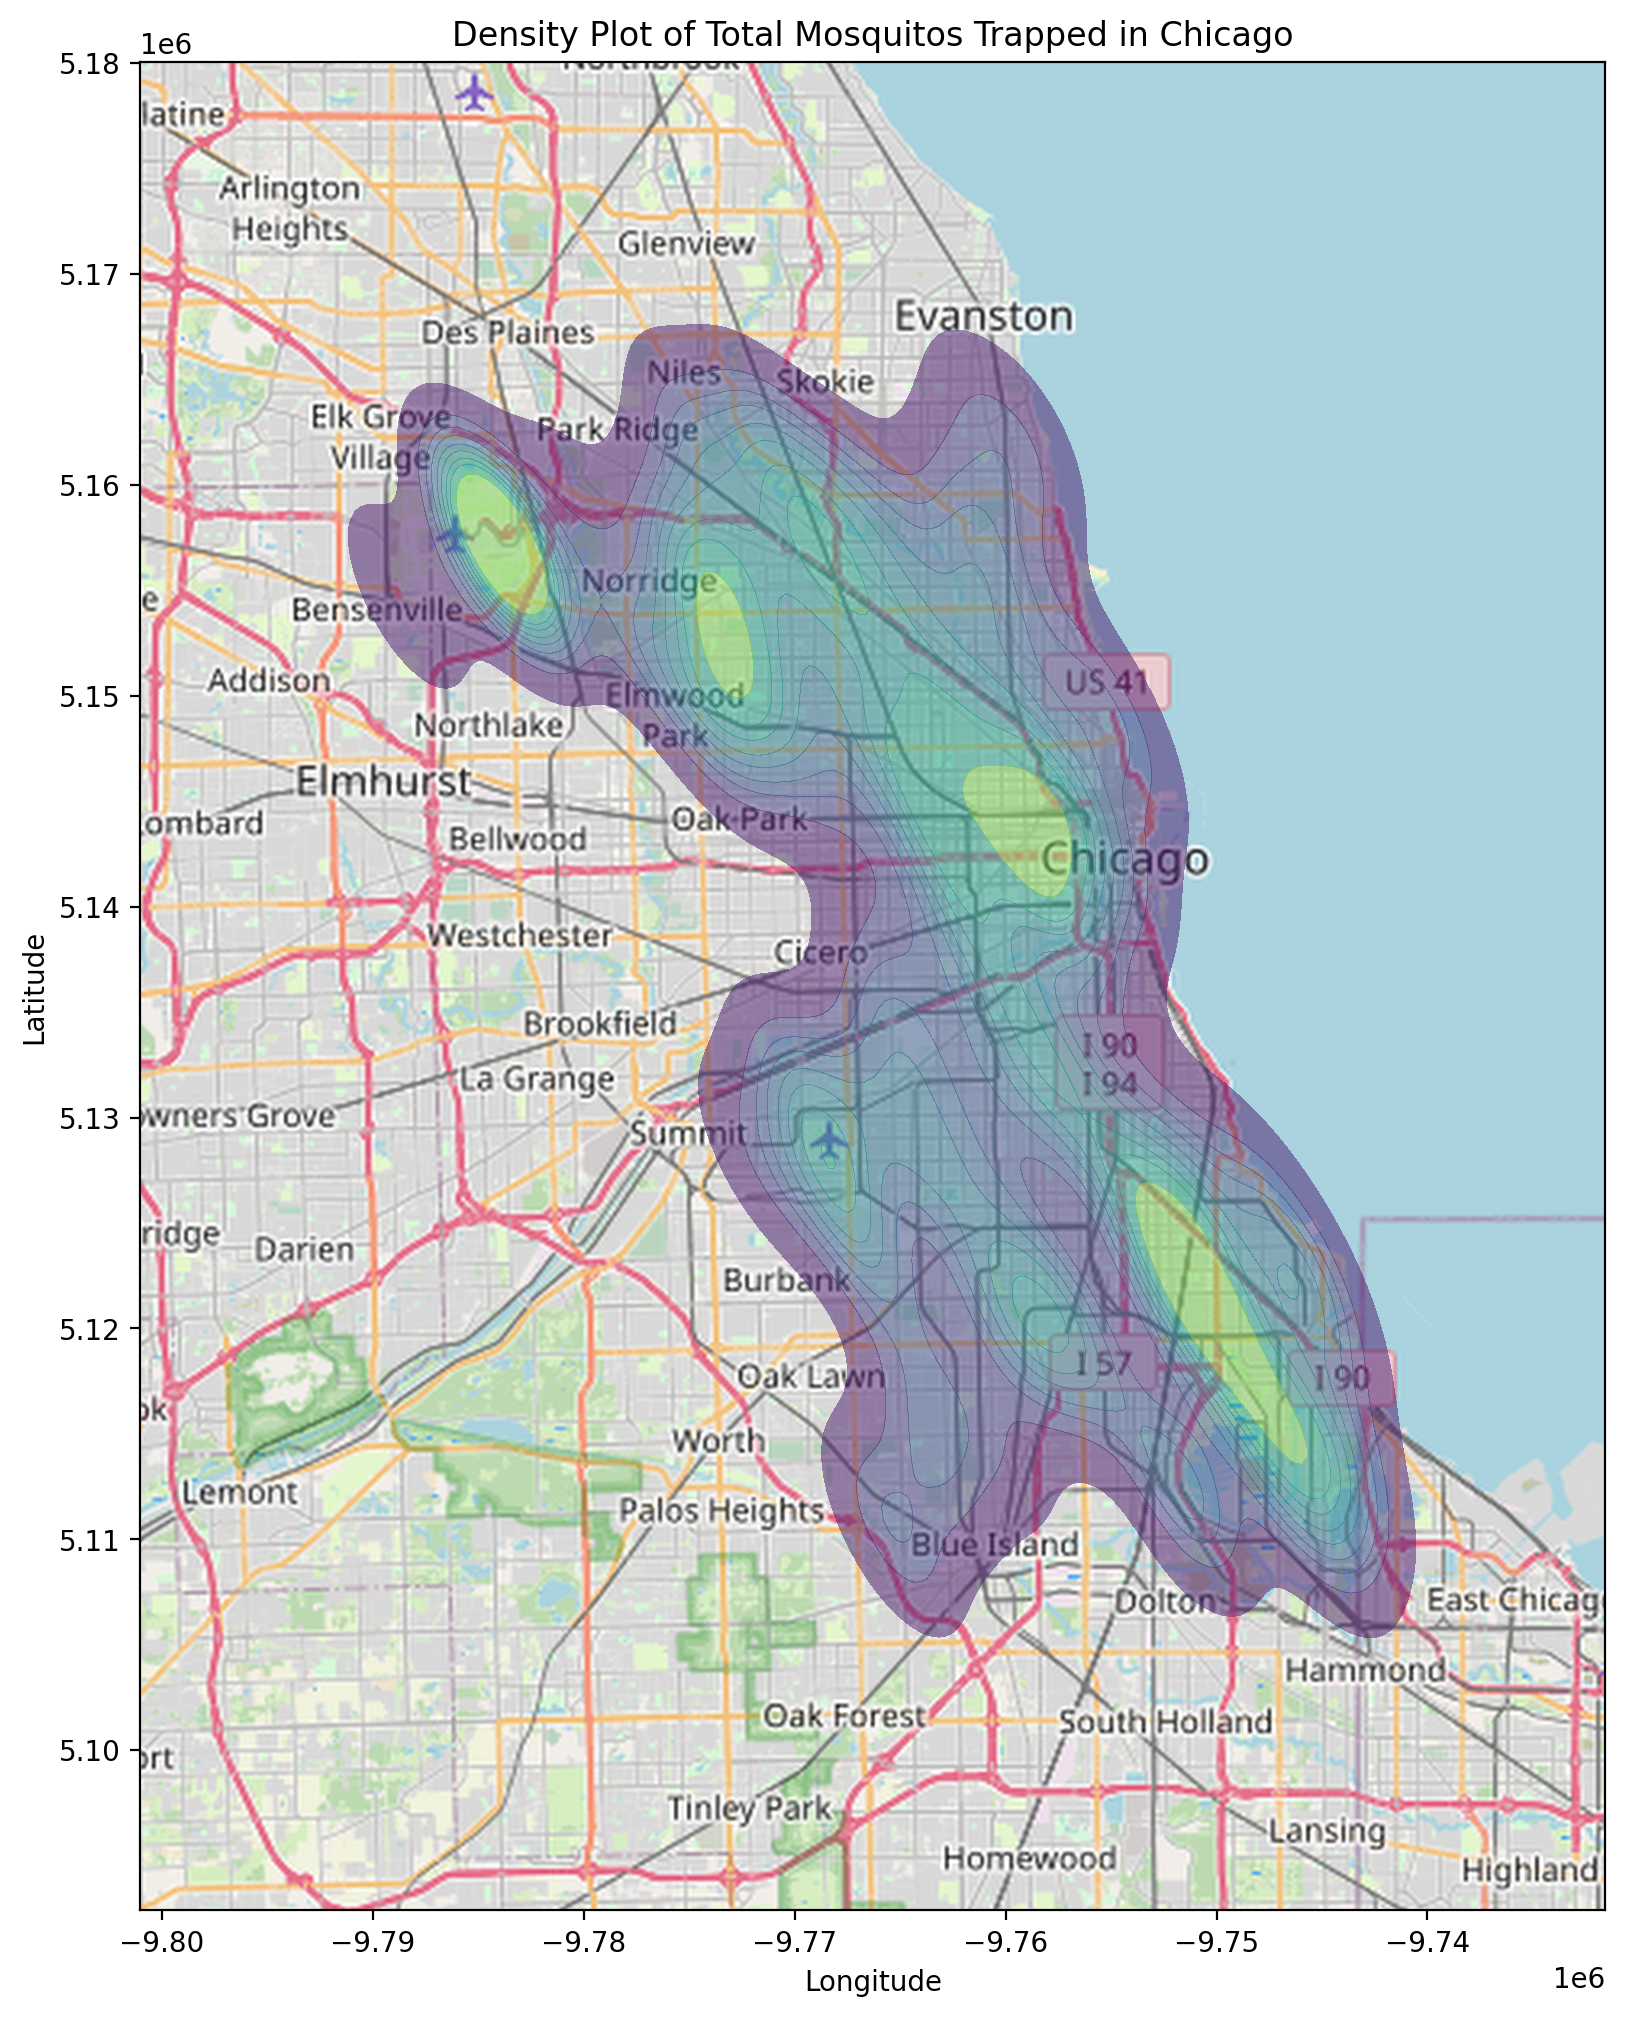

In [40]:
#Generate Geometry from longitude and latitude to prepare for mapping
geometry = [Point(xy) for xy in zip( combined_df['longitude'], combined_df['latitude'])]
geometry[:3]
geo_df = gpd.GeoDataFrame(combined_df, geometry=geometry)

geo_df = geo_df.set_crs('epsg:4326')
geo_df = geo_df.to_crs("EPSG:3857")

#generate street map of Chicago
street_map = gpd.read_file('../media/city boundaries google/')
street_map = street_map.to_crs("EPSG:3857")

tilemapbase.start_logging()
tilemapbase.init(create=True)
extent = tilemapbase.extent_from_frame(street_map, buffer = 25)

# density plot of total mosquito count from traps
t = tilemapbase.tiles.build_OSM()
fig,ax = plt.subplots(figsize=(12,12))
plotter = tilemapbase.Plotter(extent, t, width=250)
plotter.plot(ax)
density_plot = sns.kdeplot(
                x=geo_df['geometry'].x,
                y=geo_df['geometry'].y,
                shade=True,
                alpha=0.5,
                cmap="viridis",
                shade_lowest=False,
                zorder=3
                )
plt.title("Density Plot of Total Mosquitos Trapped in Chicago")
plt.xlabel("Longitude")
plt.ylabel("Latitude")